# Fraud Detection in Financial Transactions

In [7]:
! pip install imbalanced-learn
! pip install --upgrade scikit-learn imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.7.1-cp312-cp312-win_amd64.whl.metadata (11 kB)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
df = pd.read_csv("creditcard.csv")   
print("Data shape:", df.shape)
display(df.head())

Data shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Quick EDA / class imbalance


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


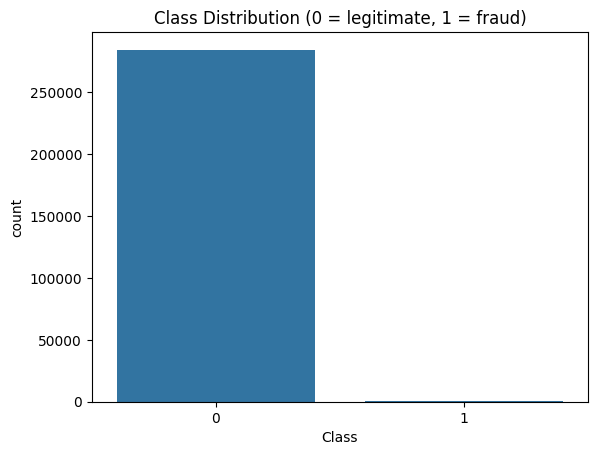

In [12]:
print("\nClass distribution:")
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = legitimate, 1 = fraud)")
plt.show()

### Basic data checks

In [13]:
print("\nMissing values:\n", df.isnull().sum().sum(), "total missing values")
print("\nData types:\n", df.dtypes.value_counts())


Missing values:
 0 total missing values

Data types:
 float64    30
int64       1
Name: count, dtype: int64


### Feature prep

In [17]:
# The dataset has PCA features V1...V28, plus 'Time' and 'Amount'
X = df.drop('Class', axis=1)
y = df['Class']
print("\nFirst 5 rows of features:")
display(X.head())
print("\nFirst 5 rows of target:")
display(y.head())


First 5 rows of features:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99



First 5 rows of target:


0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [18]:
# Scale Amount and Time (other features are already PCA scaled)
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])
print("\nScaled first 5 rows of features:")
display(X.head())


Scaled first 5 rows of features:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


### Train-test split (stratified to keep class proportion)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))


Train shape: (227845, 30) Test shape: (56962, 30)
Train class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64


### Handle imbalance with SMOTE in a pipeline

In [24]:
smote = SMOTE(random_state=42)


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


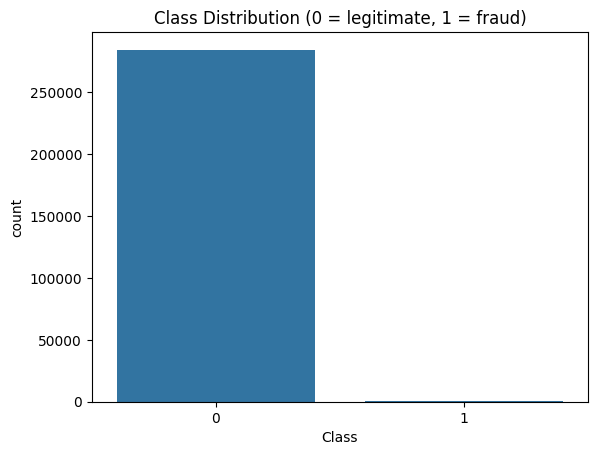

In [27]:
# We will create a helper function to train and evaluate models
def evaluate_model(clf, X_train, y_train, X_test, y_test, model_name="Model"):
    # Fit
    clf.fit(X_train, y_train)
    # Predict
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    # Metrics
    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    auc = roc_auc_score(y_test, y_proba)
    ap  = average_precision_score(y_test, y_proba)
    print(f"ROC AUC: {auc:.4f} | Avg Precision (PR-AUC): {ap:.4f}")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0,1],[0,1],'--',c='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.show()
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f'{model_name} (AP = {ap:.4f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.legend()
    plt.show()
    return clf

print("\nClass distribution:")
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = legitimate, 1 = fraud)")
plt.show()

### Model 1: Logistic Regression (with SMOTE)


=== Logistic Regression (SMOTE) ===
              precision    recall  f1-score   support

           0     0.9999    0.9744    0.9869     56864
           1     0.0581    0.9184    0.1094        98

    accuracy                         0.9743     56962
   macro avg     0.5290    0.9464    0.5481     56962
weighted avg     0.9982    0.9743    0.9854     56962

ROC AUC: 0.9698 | Avg Precision (PR-AUC): 0.7249


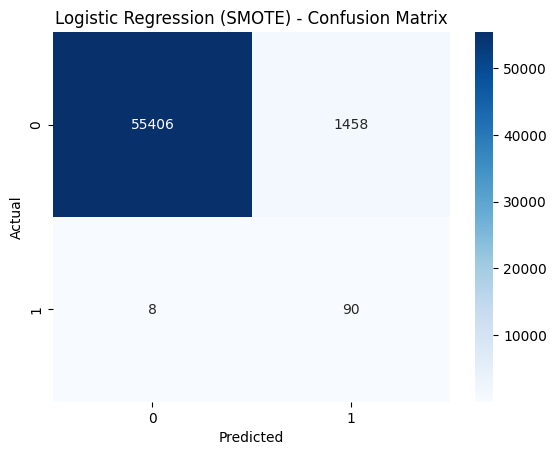

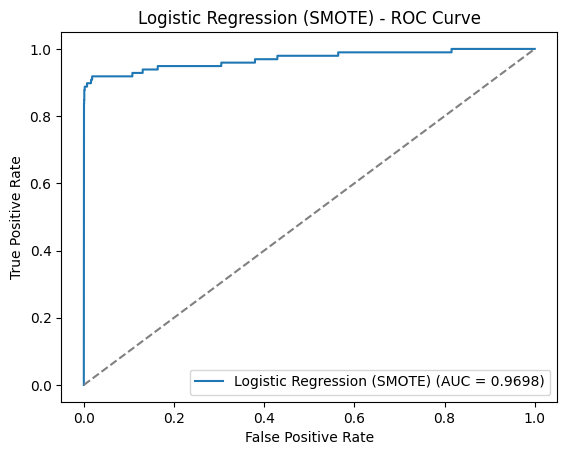

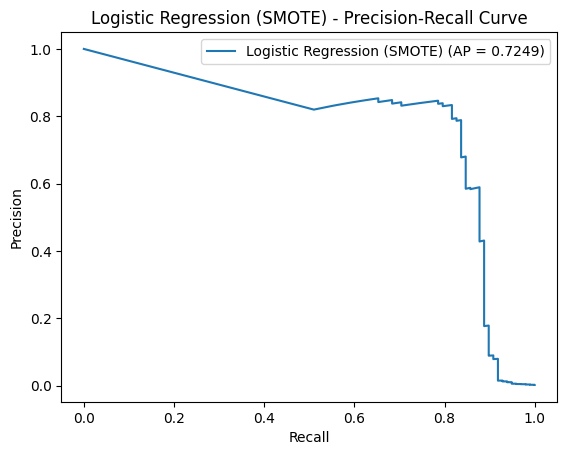

In [28]:
pipe_lr = Pipeline([
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
# Train & evaluate
lr_model = evaluate_model(pipe_lr, X_train, y_train, X_test, y_test, model_name="Logistic Regression (SMOTE)")

### Model 2: Random Forest (with SMOTE)


=== Random Forest (SMOTE) ===
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8632    0.8367    0.8497        98

    accuracy                         0.9995     56962
   macro avg     0.9314    0.9183    0.9247     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC AUC: 0.9754 | Avg Precision (PR-AUC): 0.8749


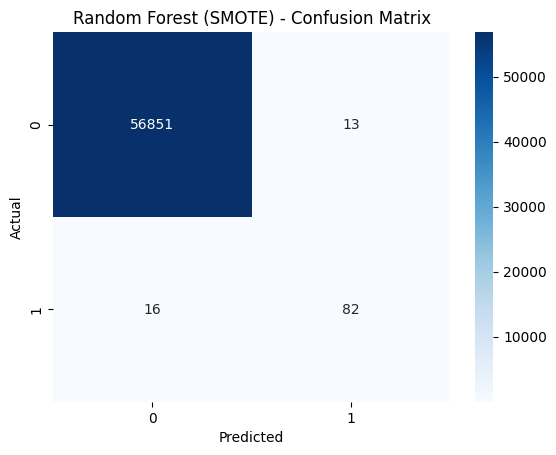

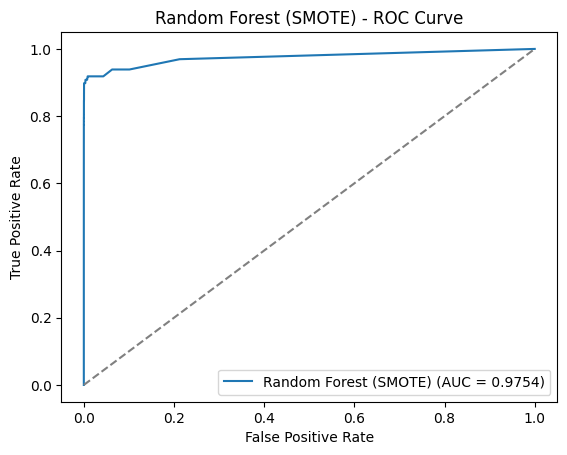

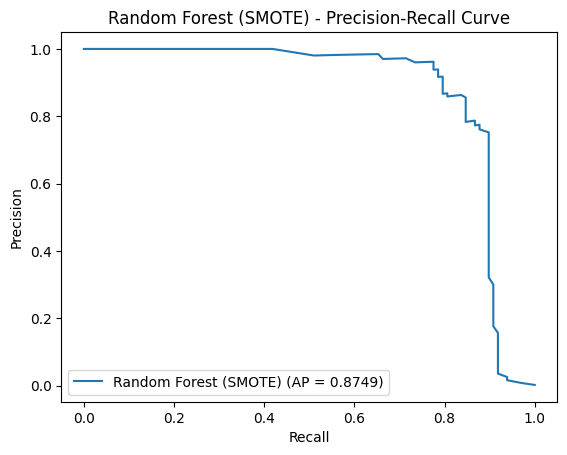

In [29]:
pipe_rf = Pipeline([
    ('smote', smote),
    ('clf', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42))
])
rf_model = evaluate_model(pipe_rf, X_train, y_train, X_test, y_test, model_name="Random Forest (SMOTE)")

### Save the best model

In [32]:
joblib.dump(rf_model, "fraud_detector_rf_smote.pkl")
print("\nSaved model to fraud_detector_rf_smote.pkl")


Saved model to fraud_detector_rf_smote.pkl


### Show feature importance for Random Forest (trained inside pipeline)

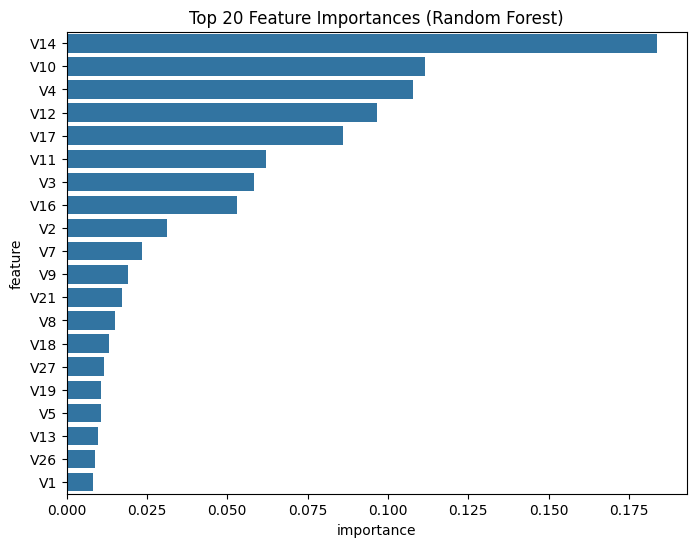

In [33]:
if hasattr(rf_model, "named_steps"):
    rf_clf = rf_model.named_steps['clf']
    if hasattr(rf_clf, "feature_importances_"):
        importances = rf_clf.feature_importances_
        feat_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(8,6))
        sns.barplot(data=feat_df.head(20), x='importance', y='feature')
        plt.title("Top 20 Feature Importances (Random Forest)")
        plt.show()
    else:
        print("RandomForest inside pipeline doesn't expose feature_importances_.")
else:
    print("Pipeline structure not found for Random Forest model.")

## Threshold tuning (choose threshold maximizing F1 or tune for constraints)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [35]:
# --- Prepare X_test and y_test (make sure these variables exist from training step)
# If X_test,y_test were computed earlier in the notebook they will be used.
try:
    X_test, y_test
except NameError:
    raise RuntimeError("X_test and y_test are not defined in this notebook. Make sure to run the train/test split cell first.")

In [39]:
import joblib
pipeline = joblib.load("fraud_detector_rf_smote.pkl")

In [40]:
# Get predicted probabilities for the positive class
if hasattr(pipeline, "predict_proba"):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
else:
    y_proba = pipeline.decision_function(X_test)

# Compute precision-recall curve data
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Add final point for threshold alignment
thresholds = np.append(thresholds, 1.0)

# Compute F1 at each threshold
f1_scores = []
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))
f1_scores = np.array(f1_scores)

# Find threshold maximizing F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precision[best_idx] if best_idx < len(precision) else precision[-1]
best_recall = recall[best_idx] if best_idx < len(recall) else recall[-1]

print(f"Best threshold by F1: {best_threshold:.4f} "
      f"(F1={best_f1:.4f}, Precision={best_precision:.4f}, Recall={best_recall:.4f})")


Best threshold by F1: 0.7750 (F1=0.8588, Precision=0.9620, Recall=0.7755)


Threshold to keep Recall >= 0.85: 0.3800 (Precision=0.7870, Recall=0.8673)


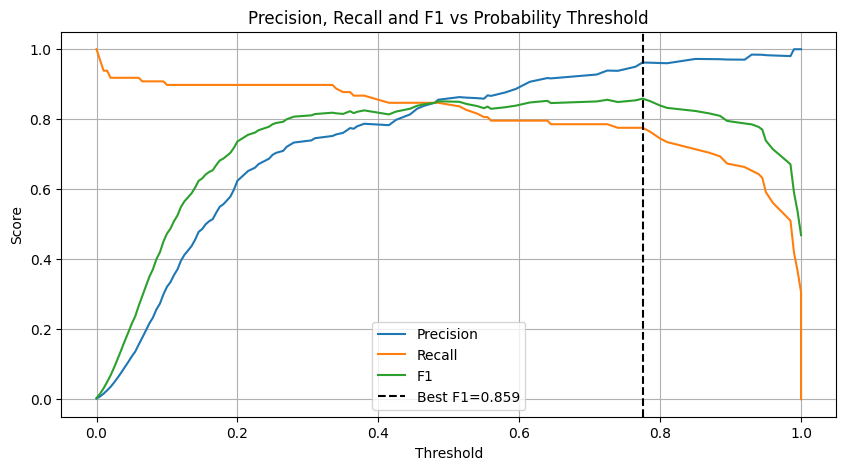

Confusion matrix at best F1 threshold:
 [[56861     3]
 [   22    76]]


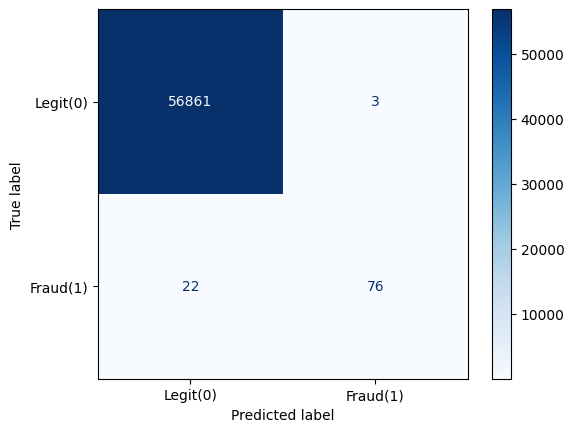

In [41]:
# Optional: choose threshold with recall >= desired value
desired_recall = 0.85
candidate_idxs = np.where(recall >= desired_recall)[0]
if candidate_idxs.size > 0:
    best_idx_rec = candidate_idxs[np.argmax(precision[candidate_idxs])]
    rec_threshold = thresholds[best_idx_rec]
    rec_precision = precision[best_idx_rec]
    rec_recall = recall[best_idx_rec]
    print(f"Threshold to keep Recall >= {desired_recall}: {rec_threshold:.4f} "
          f"(Precision={rec_precision:.4f}, Recall={rec_recall:.4f})")
else:
    print(f"No threshold found with recall >= {desired_recall}")

# Plot Precision, Recall, and F1 vs Threshold
plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, f1_scores, label="F1")
plt.axvline(best_threshold, color='k', linestyle='--', label=f"Best F1={best_f1:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 vs Probability Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Show confusion matrix for best threshold
best_preds = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, best_preds)
print("Confusion matrix at best F1 threshold:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=["Legit(0)","Fraud(1)"]).plot(cmap='Blues')
plt.show()

## Streamlined inference cell — load saved pipeline and predict on new transactions

In [42]:
import pandas as pd
import numpy as np
import joblib

In [44]:
# Load the trained pipeline
model_path = "fraud_detector_rf_smote.pkl"
pipeline = joblib.load(model_path)
print(f"Loaded pipeline from {model_path}")

# Example: single new transaction (replace values with real ones)
# The columns must match the training X columns. Example uses creditcard.csv format:
# ['Time', 'V1','V2',...,'V28','Amount'] -- adjust to your dataset features
new_txn = {
    'Time': 10000.0,
    'V1': -1.3598071336738, 'V2': -0.0727811733098497, 'V3': 2.53634673796914,
    'V4': 1.37815522427443, 'V5': -0.338320769942518, 'V6': 0.462387777762292,
    'V7': 0.239598554061257, 'V8': 0.0986979012610507, 'V9': 0.363786969611213,
    'V10': 0.0907941719789316, 'V11': -0.551599533260813, 'V12': -0.617800855762348,
    'V13': -0.991389847235408, 'V14': -0.311169353699879, 'V15': 1.46817697209427,
    'V16': -0.470400525259478, 'V17': 0.207971241929242, 'V18': 0.0257905801985591,
    'V19': 0.403992960255733, 'V20': 0.251412098239705, 'V21': -0.018306777944153,
    'V22': 0.277837575558899, 'V23': -0.110473910188767, 'V24': 0.0669280749146731,
    'V25': 0.128539358273528, 'V26': -0.189114843888824, 'V27': 0.133558376740387,
    'V28': -0.0210530534538215, 'Amount': 149.62
}

# Create DataFrame (single row)
df_new = pd.DataFrame([new_txn])

# Predict probability and label using chosen threshold
proba = pipeline.predict_proba(df_new)[:,1][0]
default_threshold = 0.5  # replace with best_threshold from tuning if you saved it
label = int(proba >= default_threshold)

print(f"Predicted fraud probability: {proba:.4f}")
print("Predicted label (1 = fraud, 0 = legitimate):", label)

# If you want to use the tuned best threshold (from tuning step) set:
# best_threshold = 0.### ; label = int(proba >= best_threshold)
best_threshold = 0.1234  # whatever value tuning gave you
label = int(proba >= best_threshold)


Loaded pipeline from fraud_detector_rf_smote.pkl
Predicted fraud probability: 0.0350
Predicted label (1 = fraud, 0 = legitimate): 0
